<a href="https://colab.research.google.com/github/casangi/examples/blob/master/casa6/CASA6_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

In [1]:
import os

print("installing pre-requisite packages...")
os.system("apt-get install libgfortran3")

print("installing casatools...")
os.system("pip install --index-url https://casa-pip.nrao.edu/repository/pypi-casa-release/simple casatools==6.0.0.27")
os.system("pip install --index-url https://casa-pip.nrao.edu/repository/pypi-casa-release/simple casatasks==6.0.0.27")

print("downloading MeasurementSet from CASAguide First Look at Imaging...")
os.system("wget https://bulk.cv.nrao.edu/almadata/public/working/sis14_twhya_calibrated_flagged.ms.tar")
os.system("tar -xvf sis14_twhya_calibrated_flagged.ms.tar")

print("building config files...")
os.system("mkdir ~/.casa")
!echo home, datapath = \'/content/\', [\'/content/\'] > ~/.casa/toolrc.py
!more /root/.casa/toolrc.py

print('complete')

installing pre-requisite packages...
installing casatools...
downloading MeasurementSet from CASAguide First Look at Imaging...
building config files...
home, datapath = '/content/', ['/content/']
complete


# Getting Started

In [2]:
import casatasks
help(casatasks)

Help on package casatasks:

NAME
    casatasks

DESCRIPTION
    ###########################################################################
    ########################## generated by setup.py ##########################
    ###########################################################################

PACKAGE CONTENTS
    accor
    accum
    applycal
    asdmsummary
    bandpass
    blcal
    calstat
    clearcal
    clearstat
    concat
    config
    conjugatevis
    cvel
    cvel2
    delmod
    exportasdm
    exportfits
    exportuvfits
    feather
    fixplanets
    fixvis
    flagcmd
    flagdata
    flagmanager
    fluxscale
    fringefit
    ft
    gaincal
    gencal
    hanningsmooth
    imcollapse
    imcontsub
    imdev
    imfit
    imhead
    imhistory
    immath
    immoments
    impbcor
    importasap
    importasdm
    importatca
    importfits
    importfitsidi
    importgmrt
    importmiriad
    importnro
    importuvfits
    importvla
    impv
    imrebin
    imreframe

In [3]:
from casatasks import listobs

rc = listobs(vis='sis14_twhya_calibrated_flagged.ms')

print(os.popen("cat casa-*.log").read())

2020-04-15 17:59:19	INFO	::casa	
2020-04-15 17:59:19	INFO	listobs::::casa	##########################################
2020-04-15 17:59:19	INFO	listobs::::casa	##### Begin Task: listobs            #####
2020-04-15 17:59:19	INFO	listobs::::casa	listobs( vis='sis14_twhya_calibrated_flagged.ms', selectdata=True, spw='', field='', antenna='', uvrange='', timerange='', correlation='', scan='', intent='', feed='', array='', observation='', verbose=True, listfile='', listunfl=False, cachesize=50.0, overwrite=False )
2020-04-15 17:59:19	INFO	listobs::ms::summary	================================================================================
2020-04-15 17:59:19	INFO	listobs::ms::summary+	           MeasurementSet Name:  /content/sis14_twhya_calibrated_flagged.ms      MS Version 2
2020-04-15 17:59:19	INFO	listobs::ms::summary+	================================================================================
2020-04-15 17:59:19	INFO	listobs::ms::summary+	   Observer: cqi     Project: uid://A002/X32

# tclean Example
Note: Only non-interactive mode is supported (interactive=False) as the CASA Viewer is not compatible.

In [4]:
from casatasks import tclean

print("running tclean, may take a bit...")

tclean(vis='sis14_twhya_calibrated_flagged.ms', imagename='first_image',
       field='5', spw='', specmode='mfs', deconvolver='hogbom', nterms=1,
       gridder='standard', imsize=[250,250], cell=['0.1arcsec'],
       weighting='natural', threshold='0mJy', niter=5000, 
       interactive=False, savemodel='modelcolumn')

print("complete")

running tclean, may take a bit...
complete


# View Images with astropy


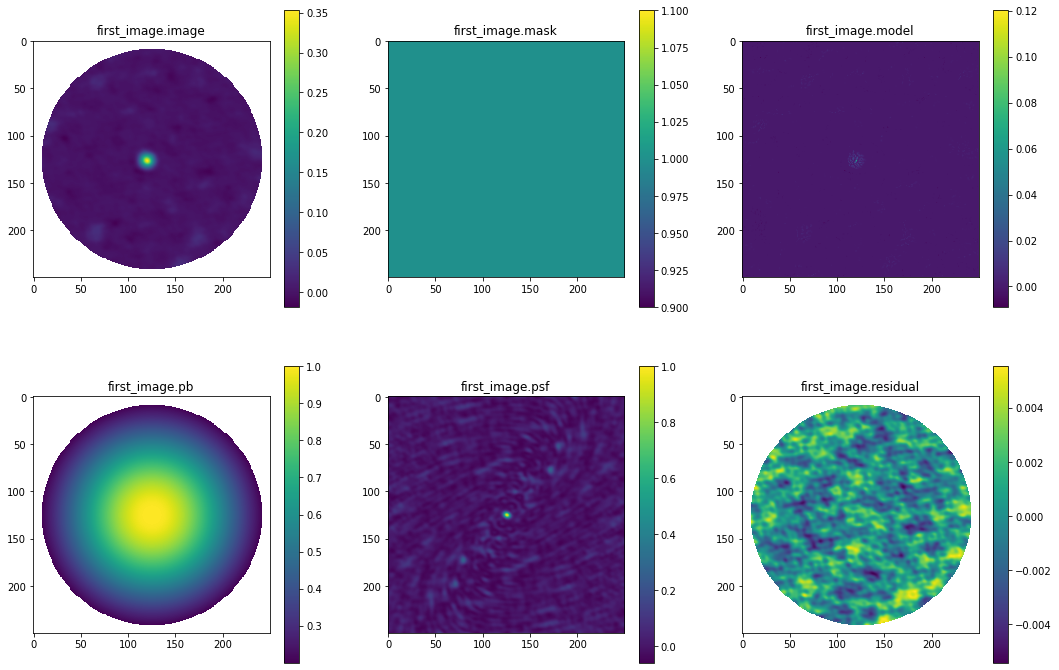

In [5]:
import matplotlib.pyplot as plt
from astropy.io import fits
from casatasks import exportfits

filenames = ['first_image.image', 'first_image.mask', 'first_image.model', 
             'first_image.pb', 'first_image.psf', 'first_image.residual']

ff, aa = plt.subplots(2,3, figsize=(18,12))
for ii, name in enumerate(filenames):
  exportfits(imagename=name, fitsimage=name+'.fits', overwrite=True)
  xx,yy = int(ii/3),ii%3
  im = aa[xx,yy].imshow(fits.getdata(name+'.fits')[0,0,:,:])
  plt.colorbar(im, ax=aa[xx,yy])
  aa[xx,yy].set_title(name)


# View Images with CARTA
Consider this very experimental, even a bit magical

In [6]:
import os
import subprocess as sp
import socket
import signal
import time
import requests

FRONT_PORT = '39138'  # make something up
BACK_PORT = '41578'
HOST_IP = socket.gethostbyname(socket.gethostname()) 

print("downloading ngrok...")
os.system("wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip")
os.system("unzip -o ngrok-stable-linux-amd64.zip");

print("downloading CARTA...")
os.system("wget https://github.com/CARTAvis/carta-releases/releases/download/v1.1/CARTA-v1.1-remote.tar.gz")
os.system("tar -xvf CARTA-v1.1-remote.tar.gz")
os.system("rm CARTA-v1.1-remote/carta-backend/lib/libstdc++.so.6")
os.system("rm -r sample_data")

cp = sp.Popen('CARTA-v1.1-remote/carta --port='+BACK_PORT + ' --fport='+FRONT_PORT, shell=True, preexec_fn=os.setsid, stdin=sp.PIPE, stdout=sp.PIPE, stderr=sp.STDOUT)
gp1 = sp.Popen('./ngrok http ' + HOST_IP+':'+FRONT_PORT, shell=True, preexec_fn=os.setsid, stdin=sp.PIPE, stdout=sp.PIPE, stderr=sp.STDOUT)
gp2 = sp.Popen('./ngrok http ' + HOST_IP+':'+BACK_PORT, shell=True, preexec_fn=os.setsid, stdin=sp.PIPE, stdout=sp.PIPE, stderr=sp.STDOUT)

time.sleep(2) # give the processes time to start
fcon = requests.get('http://localhost:4040/api/tunnels').json()['tunnels']
bcon = requests.get('http://localhost:4041/api/tunnels').json()['tunnels']
furl = [fcon[ii]['public_url'] for ii in range(len(fcon)) if fcon[ii]['proto'] == 'https'][0]
burl = [bcon[ii]['public_url'] for ii in range(len(bcon)) if bcon[ii]['proto'] == 'https'][0]
print('click this -> ' + furl +'/?socketUrl=' + burl.replace('https','wss'))

downloading ngrok...
downloading CARTA...
click this -> https://51f8f35f.ngrok.io/?socketUrl=wss://e90d7a5b.ngrok.io


In [7]:
# turn it off
os.killpg(os.getpgid(gp1.pid), signal.SIGTERM)
os.killpg(os.getpgid(gp2.pid), signal.SIGTERM)
os.killpg(os.getpgid(cp.pid), signal.SIGTERM)
print("stopped CARTA and the secure tunnels")

stopped CARTA and the secure tunnels
